In [2]:
# disabling contracts for speed
import contracts
import yaml
import numpy as np
import geometry as geo
import numpy as np
from duckietown_world.world_duckietown.tile_template import load_tile_types
from duckietown_world.geo.measurements_utils import iterate_by_class
from duckietown_world.world_duckietown.tile import get_lane_poses
import duckietown_world as dw
from copy import deepcopy
import geometry as g
import pandas as pd

contracts.disable_all()
m = dw.load_map('ethz_amod_lab_k31')


INFO:dt-world:loading map ethz_amod_lab_k31


In [3]:
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_svg, ipython_draw_html

class Person(dw.PlacedObject):
    def __init__(self, radius, *args, **kwargs):

        self.radius = radius

        dw.PlacedObject.__init__(self, *args, **kwargs)

        

    def draw_svg(self, drawing, g):

        # drawing is done using the library svgwrite

        c = drawing.circle(center=(0, 0), r=self.radius, fill='pink')

        g.add(c)

        # draws x,y axes

        dw.draw_axes(drawing, g)


    def extent_points(self):

        # set of points describing the boundary 

        L = self.radius

        return [(-L, -L), (+L, +L)]

def relative_pose(q0, q1):
    return g.SE2.multiply(g.SE2.inverse(q0), q1)

def interpolate(q0, q1, alpha):
    q1_from_q0 = relative_pose(q0, q1)
    vel = g.SE2.algebra_from_group(q1_from_q0)
    rel = g.SE2.group_from_algebra(vel * alpha)
    q = g.SE2.multiply(q0, rel)
    return q

In [4]:
def calculatePose(qPose):
    timestamps = 1 # [0, 1, 2, ...]
    transforms = dw.SE2Transform.from_SE2(qPose)
    width = 0.188
    counter = 0
    center_points2 = []
    
    notWantedTiles = ['3way_left', '4way', 'asphalt']
    
    timestamp = 1
    pose_object = transforms
    hoi = list(get_lane_poses(m, pose_object.as_SE2()))
    
    try:
        tile = list(hoi[0].tile.children.keys())[0]
        if tile in notWantedTiles:
            return -100, -100
        
    except:
        print('error: ' + str(hoi))

    
    if len(hoi) == 0:
        return width, 0

    else:
        distance_from_left = hoi[0].lane_pose.distance_from_left
        distance_from_right = hoi[0].lane_pose.distance_from_right
        distance_from_center = hoi[0].lane_pose.distance_from_center
        rel_heading = hoi[0].lane_pose.relative_heading
        correct_direction = hoi[0].lane_pose.correct_direction        
        alongInside = hoi[0].lane_pose.along_inside
        outsideLeft = hoi[0].lane_pose.outside_left
        inside = hoi[0].lane_pose.inside
        lateral = hoi[0].lane_pose.lateral
        lateral_left = hoi[0].lane_pose.lateral_left
        width = lateral_left
        tile = list(hoi[0].tile.children.keys())[0]

        correctDir = hoi[0].lane_pose.correct_direction
        return distance_from_center, rel_heading
        







In [5]:

root = dw.PlacedObject()
import sys
import traceback



realTimestamps = []
with open("trajectory2Pose/autobot29/autobot29.yaml", 'r') as stream:

    try:

        data = yaml.safe_load(stream)

    except yaml.YAMLError as exc:

        print(exc)

    

    timestart = data['begin_time_stamp']
    data_points = len(data['trajectory_data'])

    x = np.zeros((data_points,))

    y= np.zeros((data_points,))

    R = np.zeros((3,3, data_points))            
    phi = np.zeros((3, data_points))

    

    dx = 999.999*np.ones((data_points, ))

    dy = 999.999*np.ones((data_points, ))

    dr = 999.999*np.ones((data_points, ))
    dphi = 999.999*np.ones((data_points, ))

    final_trajectory = []

    for idx, [time, traj] in enumerate(data['trajectory_data'].items()):

        x[idx] = np.array(traj[0])

        y[idx] = np.array(traj[1])

        R[:,:,idx] = np.reshape(np.array(traj[3:]), (3,3))
        

        phi[:,idx] = np.array([np.arctan2(-R[1,2,idx],R[2,2,idx]), 
                               np.arctan2(R[0,2,idx],np.sqrt(R[0,0,idx]**2 + R[0,1,idx]**2)),
                               np.arctan2(-R[0,1,idx], R[0,0,idx])])

        realTimestamps.append(time)
        #print(phi[:,idx])
        z = phi[2,idx]
        points = np.array([x[idx], y[idx]])
        final_trajectory.append([points, z])
    final_array = final_trajectory
    
seqs2 = []

for entry in range(0, len(final_array)):
    x =  (final_array[entry][0][0] )  # -2.2
    y = final_array[entry][0][1] # + 0.8
    alpha = final_array[entry][1]
    q5 = geo.SE2_from_translation_angle([x,y],alpha)
    seqs2.append(q5)

trajectoryFile = 'autobot29.yaml'
path = 'trajectory2Pose/'+str(trajectoryFile.split('.')[0]) + '/image_timestamps.csv'
imagesDFcolumns = ['ImageName', 'Seconds', 'Nanoseconds']
imagesDF = pd.read_csv(path)
timeStampImagesSecondsArray = imagesDF.iloc[:,1]
timeStampImagesNanoSecArray = imagesDF.iloc[:,2]
imageNumber = imagesDF.iloc[:,0]

global entryNumberTrajectory
entryNumberTrajectory = 0
finalArrayWithoutPose = []
finalArrayPoses = []
print(len(timeStampImagesSecondsArray))
print(len(realTimestamps))
counter = 0

for entry in range(0, len(timeStampImagesSecondsArray)-1):
    timeStampImagesSeconds = imagesDF.iloc[entry, 1]
    timeStampImagesNanoSec = imagesDF.iloc[entry,2] * (10**(-9))
    imageNumber = imagesDF.iloc[entry,0]
    # Check if exact time is available in both dataframes
    timeStampImages = float(timeStampImagesSeconds) + float(timeStampImagesNanoSec)
    timeStampTrajectory = int(timestart) + float(realTimestamps[entryNumberTrajectory])
    timeStampTrajectoryAfter = int(timestart) + float(realTimestamps[entryNumberTrajectory + 1]) 
    
    if timeStampImages == timeStampTrajectory:
        q2 = seqs2[entryNumberTrajectory]
        finalArrayPoses.append(q2)
        counter += 1
        centerDistance, relativeHeading = calculatePose(q2)
        finalArrayWithoutPose.append([imageNumber, counter, centerDistance, relativeHeading])
        #entryNumberTrajectory += 1
        
    elif timeStampImages < timeStampTrajectory:
        if entryNumberTrajectory == 0:
            continue
        while timeStampImages < timeStampTrajectory:
            entryNumberTrajectory -= 1
            timeStampTrajectory = int(timestart) + float(realTimestamps[entryNumberTrajectory])
            timeStampTrajectoryAfter = int(timestart) + float(realTimestamps[entryNumberTrajectory + 1]) 
            
        if timeStampImages > timeStampTrajectory and timeStampImages < timeStampTrajectoryAfter:
            timeStampTrajectory = int(timestart) + float(realTimestamps[entryNumberTrajectory])
            timeStampTrajectoryAfter = int(timestart) + float(realTimestamps[entryNumberTrajectory + 1]) 
            
            timeStamp1 = timeStampTrajectory
            timeStampWanted = timeStampImages
            timeStamp2 = timeStampTrajectoryAfter            
            param = (timeStampWanted- timeStamp1) / (timeStamp2 - timeStamp1)
            q2 = seqs2[entryNumberTrajectory+1]
            q1 = seqs2[entryNumberTrajectory]

            qInter = interpolate(q1, q2, param)
            centerDistance, relativeHeading = calculatePose(qInter)
            if centerDistance == -100 and relativeHeading == -100:
                continue

            print(counter)
            counter += 1
            finalArrayPoses.append(qInter)
            finalArrayWithoutPose.append([imageNumber, timeStampImages, centerDistance, relativeHeading])
            continue

    
    elif timeStampImages > timeStampTrajectory:
            
        if timeStampImages < timeStampTrajectoryAfter:
            timeStampTrajectory = int(timestart) + float(realTimestamps[entryNumberTrajectory])
            timeStampTrajectoryAfter = int(timestart) + float(realTimestamps[entryNumberTrajectory + 1]) 
            timeStamp1 = timeStampTrajectory
            timeStampWanted = timeStampImages
            timeStamp2 = timeStampTrajectoryAfter

            param = (timeStampWanted- timeStamp1)/ (timeStamp2 - timeStamp1)

            q2 = seqs2[entryNumberTrajectory+1]
            q1 = seqs2[entryNumberTrajectory]

            qInter = interpolate(q1, q2, param)
            centerDistance, relativeHeading = calculatePose(qInter)
            if centerDistance == -100 and relativeHeading == -100:
                continue
            print(counter)
            counter += 1
            finalArrayPoses.append(qInter)
            finalArrayWithoutPose.append([imageNumber, timeStampImages, centerDistance, relativeHeading])
            
        else:
            while timeStampImages > timeStampTrajectoryAfter:
                entryNumberTrajectory += 1
                #print(entryNumberTrajectory, timeStampImages, timeStampTrajectory, timeStampTrajectoryAfter)
                timeStampTrajectoryAfter = int(timestart) + float(realTimestamps[entryNumberTrajectory + 1]) 
            timeStampTrajectory = int(timestart) + float(realTimestamps[entryNumberTrajectory])
            timeStampTrajectoryAfter = int(timestart) + float(realTimestamps[entryNumberTrajectory + 1]) 
            timeStamp1 = timeStampTrajectory
            timeStampWanted = timeStampImages
            timeStamp2 = timeStampTrajectoryAfter
            #print(str(timeStamp1) + ' ' + str(timeStampWanted) + ' ' + str(timeStamp2))

            param = (timeStampWanted- timeStamp1) / (timeStamp2 - timeStamp1)

            q2 = seqs2[entryNumberTrajectory+1]
            q1 = seqs2[entryNumberTrajectory]
            qInter = interpolate(q1, q2, param)
            centerDistance, relativeHeading = calculatePose(qInter)
            
            if centerDistance == -100 and relativeHeading == -100:
                continue
                
            print(counter)
            counter += 1
            finalArrayPoses.append(qInter)
            finalArrayWithoutPose.append([imageNumber, timeStampImages, centerDistance, relativeHeading])
    else:
        print('unhandled')
finalArrayWithoutPose = np.array(finalArrayWithoutPose)
print(finalArrayWithoutPose)






866
677
('tilemap', 'tile-3-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.41743576364510804,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.8287293427503855,relative_heading=-3.125343513915638,distance_from_left=0.22943576364510804,distance_from_right=0.605435763645108,distance_from_center=0.41743576364510804,center_point=SE2Transform([0.32872934275038546, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-3-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.02256423635489191,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.17127065724961454,relative_heading=0.016249139674155425,distance_from_left=0.1654357636451081,distance_from_right=0.2105642363548919,distance_from_center=0.02256423635489191,center_point=SE2Transform

('tilemap', 'tile-3-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.02598972730511062,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.28615939708880234,relative_heading=-0.00048197985220388846,distance_from_left=0.16201027269488938,distance_from_right=0.21398972730511062,distance_from_center=0.02598972730511062,center_point=SE2Transform([-0.21384060291119766, -0.2199999988079071],0.0),correct_direction=True)
10
('tilemap', 'tile-3-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4140036426830245,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6803070815118963,relative_heading=3.1361900138995393,distance_from_left=0.22600364268302447,distance_from_right=0.6020036426830244,distance_from_center=0.4140036426830245,center_point=SE2Transform(

('tilemap', 'tile-3-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.41741758284681363,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4138687207278875,relative_heading=3.1194288068602476,distance_from_left=0.22941758284681363,distance_from_right=0.6054175828468136,distance_from_center=0.41741758284681363,center_point=SE2Transform([-0.0861312792721125, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-3-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.022582417153186346,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5861312792721125,relative_heading=-0.022163846729545366,distance_from_left=0.16541758284681365,distance_from_right=0.21058241715318635,distance_from_center=0.022582417153186346,center_point=SE2Transform([0

('tilemap', 'tile-3-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.44676279500654625,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.014849819584631607,relative_heading=3.1046576067311586,distance_from_left=0.25876279500654625,distance_from_right=0.6347627950065462,distance_from_center=0.44676279500654625,center_point=SE2Transform([-0.4851501804153684, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-3-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.006762795006546224,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9851501804153684,relative_heading=-0.03693504685863452,distance_from_left=0.19476279500654622,distance_from_right=0.18123720499345378,distance_from_center=0.006762795006546224,center_point=SE2Transform(

('tilemap', 'tile-4-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.45617997586671355,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6387968572710756,relative_heading=3.03556794522525,distance_from_left=0.26817997586671355,distance_from_right=0.6441799758667135,distance_from_center=0.45617997586671355,center_point=SE2Transform([0.1387968572710756, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-4-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.016179975866713603,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3612031427289244,relative_heading=-0.106024708364543,distance_from_left=0.2041799758667136,distance_from_right=0.1718200241332864,distance_from_center=0.016179975866713603,center_point=SE2Transform([-0.13879

('tilemap', 'tile-4-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.48067297252291374,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.20379383674617202,relative_heading=3.1148475088523466,distance_from_left=0.29267297252291374,distance_from_right=0.6686729725229137,distance_from_center=0.48067297252291374,center_point=SE2Transform([-0.296206163253828, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-4-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.040672972522913714,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.796206163253828,relative_heading=-0.026745144737446692,distance_from_left=0.22867297252291371,distance_from_right=0.1473270274770863,distance_from_center=0.040672972522913714,center_point=SE2Transform([0.

('tilemap', 'tile-5-2', '3way_left', 'west_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4867509607091552,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=1.0645848467574648,relative_heading=-3.122345804122932,distance_from_left=0.2987509607091552,distance_from_right=0.6747509607091552,distance_from_center=0.4867509607091552,center_point=SE2Transform([0.2165317073882706, 0.4435925169245308],1.4915936737222155),correct_direction=False)
('tilemap', 'tile-5-2', '3way_left', 'north_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.04926858215289362,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.01674944567048294,relative_heading=-0.08342351277208479,distance_from_left=0.23726858215289362,distance_from_right=0.13873141784710638,distance_from_center=0.04926858215289362,ce

('tilemap', 'tile-5-2', '3way_left', 'north_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.0660547507340147,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.11577490973599108,relative_heading=-0.22602267764189932,distance_from_left=0.25405475073401473,distance_from_right=0.1219452492659853,distance_from_center=0.0660547507340147,center_point=SE2Transform([-0.3849638727116675, -0.20811918481016886],0.16221264654882722),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'north_go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.02262593303509025,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.14221296815981577,relative_heading=0.4414906444272896,distance_from_left=0.21062593303509025,distance_from_right=0.16537406696490975,distance_from_center=0.0226259330350

('tilemap', 'tile-5-2', '3way_left', 'north_go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.07032672985449212,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2524474135753324,relative_heading=0.9302407942862323,distance_from_left=0.11767327014550788,distance_from_right=0.2583267298544921,distance_from_center=0.07032672985449212,center_point=SE2Transform([-0.2793650327641627, -0.3236502479022331],-0.896977590408416),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5458128453356255,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.34656996301547127,relative_heading=2.8354664521696535,distance_from_left=0.35781284533562546,distance_from_right=0.7338128453356254,distance_from_center=0.5458128453356255,ce

('tilemap', 'tile-5-2', '3way_left', 'west_go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.30715456264371643,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.18854903272119383,relative_heading=-0.6505632229010724,distance_from_left=0.11915456264371643,distance_from_right=0.49515456264371643,distance_from_center=0.30715456264371643,center_point=SE2Transform([-0.31145096727880617, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'west_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.25904298574736423,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3077678211283033,relative_heading=-1.0817778349584917,distance_from_left=0.07104298574736423,distance_from_right=0.44704298574736423,distance_from_center=0.25904298574736423,center_p

('tilemap', 'tile-5-2', '3way_left', 'north_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.21332342883643923,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.33917912822048735,relative_heading=0.6241701526356453,distance_from_left=0.40132342883643923,distance_from_right=0.025323428836439232,distance_from_center=0.21332342883643923,center_point=SE2Transform([-0.1752463664524454, -0.1338100759166664],0.47522510851645594),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'north_go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.17632436358314352,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.33085458655929867,relative_heading=2.27496346103234,distance_from_left=0.011675636416856483,distance_from_right=0.3643243635831435,distance_from_center=0.17632436358314

('tilemap', 'tile-5-2', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6077471736778607,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.29286329419231494,relative_heading=-2.4525118730149247,distance_from_left=0.4197471736778607,distance_from_right=0.7957471736778607,distance_from_center=0.6077471736778607,center_point=SE2Transform([-0.2569044089738847, -0.3572085317329855],-1.0405803296084135),correct_direction=False)
('tilemap', 'tile-5-2', '3way_left', 'east_go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.17014104177001182,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7673978455877748,relative_heading=2.7900931045562487,distance_from_left=0.017858958229988176,distance_from_right=0.3581410417700118,distance_from_center=0.170141041770011

('tilemap', 'tile-5-2', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.12026163262318779,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4495457018791325,relative_heading=-0.888686546848177,distance_from_left=0.06773836737681221,distance_from_right=0.3082616326231878,distance_from_center=0.12026163262318779,center_point=SE2Transform([-0.08268090700975578, -0.07390879520653051],0.6298601157431506),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'north_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.09934706966646863,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.45052306745418963,relative_heading=0.6807403894895188,distance_from_left=0.2873470696664686,distance_from_right=0.08865293033353137,distance_from_center=0.09934706966646863,

('tilemap', 'tile-5-2', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.3718932933470661,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2322958410340586,relative_heading=1.9580389075500755,distance_from_left=0.1838932933470661,distance_from_right=0.5598932933470662,distance_from_center=0.3718932933470661,center_point=SE2Transform([-0.29230456215912964, -0.3082074201578849],-0.8253765026197113),correct_direction=False)
('tilemap', 'tile-5-2', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4525395553816457,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.24140010740508416,relative_heading=-2.722001462107168,distance_from_left=0.2645395553816457,distance_from_right=0.6405395553816458,distance_from_center=0.4525395553816457,ce

('tilemap', 'tile-5-2', '3way_left', 'west_go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.09550315581844096,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.722311518367762,relative_heading=-0.6316168541310022,distance_from_left=0.09249684418155904,distance_from_right=0.283503155818441,distance_from_center=0.09550315581844096,center_point=SE2Transform([0.22231151836776197, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'west_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.2466015942525281,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6119845937577687,relative_heading=-1.4890706694403024,distance_from_left=0.4346015942525281,distance_from_right=0.05860159425252809,distance_from_center=0.2466015942525281,center_point=SE2

('tilemap', 'tile-5-2', '3way_left', 'north_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.013465453953609138,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.8996539948834241,relative_heading=-0.3405377872668752,distance_from_left=0.17453454604639085,distance_from_right=0.20146545395360915,distance_from_center=0.013465453953609138,center_point=SE2Transform([0.18117272192839265, 0.28287197592400465],1.2605084580995105),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.7499305040010087,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.1981243994169205,relative_heading=1.623931738222297,distance_from_left=0.5619305040010087,distance_from_right=0.9379305040010086,distance_from_center=0.7499305040010087,c

('tilemap', 'tile-5-2', '3way_left', 'west_go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.026935153881034707,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9011702708282989,relative_heading=-0.5256921350289836,distance_from_left=0.2149351538810347,distance_from_right=0.1610648461189653,distance_from_center=0.026935153881034707,center_point=SE2Transform([0.4011702708282989, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'west_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.46190073195957854,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6268320658106282,relative_heading=-1.4039487973605465,distance_from_left=0.6499007319595785,distance_from_right=0.27390073195957854,distance_from_center=0.46190073195957854,center_poin

('tilemap', 'tile-5-2', '3way_left', 'north_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.0641776222814375,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=1.0903460456316192,relative_heading=-0.2719519822615011,distance_from_left=0.2521776222814375,distance_from_right=0.1238223777185625,distance_from_center=0.0641776222814375,center_point=SE2Transform([0.21866637751610898, 0.4692637166461378],1.527687783034643),correct_direction=True)
('tilemap', 'tile-5-2', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.9612564469552309,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.19156498152804652,relative_heading=1.9363904261894973,distance_from_left=0.773256446955231,distance_from_right=1.1492564469552309,distance_from_center=0.9612564469552309,center_

('tilemap', 'tile-5-2', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.99322081906444,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.1908067970418464,relative_heading=2.058189776801096,distance_from_left=0.8052208190644401,distance_from_right=1.18122081906444,distance_from_center=0.99322081906444,center_point=SE2Transform([-0.3227319916111065, -0.2800831529222542],-0.6779606999747921),correct_direction=False)
('tilemap', 'tile-5-2', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5202206266217094,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.0022854353065788783,relative_heading=2.959145844529055,distance_from_left=0.3322206266217094,distance_from_right=0.7082206266217095,distance_from_center=0.5202206266217094,center_po

('tilemap', 'tile-5-2', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5251261056430071,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.00010309987584249328,relative_heading=2.9895334057803216,distance_from_left=0.3371261056430071,distance_from_right=0.7131261056430072,distance_from_center=0.5251261056430071,center_point=SE2Transform([-0.49989690756238014, -0.2199987606623309],-0.0003663269080407101),correct_direction=False)
('tilemap', 'tile-5-2', '3way_left', 'east_go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5251273097459548,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.00029546016572806755,relative_heading=2.989167078872281,distance_from_left=0.3371273097459548,distance_from_right=0.7131273097459547,distance_from_center=0.52512730

103
('tilemap', 'tile-5-3', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5939535468938157,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.39962873292225076,relative_heading=-3.0475743767032033,distance_from_left=0.40595354689381574,distance_from_right=0.7819535468938157,distance_from_center=0.5939535468938157,center_point=SE2Transform([-0.10037126707774924, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-5-3', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.15395354689381577,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6003712670777492,relative_heading=0.09401827688658984,distance_from_left=0.34195354689381574,distance_from_right=0.03404645310618423,distance_from_center=0.15395354689381577,center_point=SE2Transform(

('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.046929544183113625,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.13001567470195524,relative_heading=0.3582953301037011,distance_from_left=0.23492954418311363,distance_from_right=0.14107045581688638,distance_from_center=0.046929544183113625,center_point=SE2Transform([-0.37099047408833663, -0.20537386334507945],0.18216543406795874),correct_direction=True)
119
('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4780867675155834,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3876341781042586,relative_heading=-2.7951801016030213,distance_from_left=0.2900867675155834,distance_from_right=0.6660867675155834,distance_from_center=0.47808

('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.0027189357893271614,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3941443470853389,relative_heading=0.43559950986199325,distance_from_left=0.18528106421067284,distance_from_right=0.19071893578932717,distance_from_center=0.0027189357893271614,center_point=SE2Transform([-0.12798830126381205, -0.1057680060631896],0.5522370763127163),correct_direction=True)
135
('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.42920132398089633,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2851037591396428,relative_heading=-2.699305857234557,distance_from_left=0.24120132398089633,distance_from_right=0.6172013239808963,distance_from_center=0.42920

144
('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.43176536913801516,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.27533770165515,relative_heading=-2.638150938845534,distance_from_left=0.24376536913801516,distance_from_right=0.6197653691380152,distance_from_center=0.43176536913801516,center_point=SE2Transform([-0.26605076129547356, -0.34226224970850844],-0.9783096811400386),correct_direction=False)
('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.0037396798031730967,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4240212913133305,relative_heading=0.5018305890094981,distance_from_left=0.1917396798031731,distance_from_right=0.1842603201968269,distance_from_center=0.00373967

('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.3470536821240306,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.18998648546520333,relative_heading=-2.876236325037771,distance_from_left=0.1590536821240306,distance_from_right=0.5350536821240306,distance_from_center=0.3470536821240306,center_point=SE2Transform([-0.3233778570573398, -0.2795774174232291],-0.675046029117567),correct_direction=False)
('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.07933127786811398,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6384729399624933,relative_heading=0.2665398928416174,distance_from_left=0.10866872213188603,distance_from_right=0.26733127786811395,distance_from_center=0.0793312778681139

('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.3383094831245778,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.14275554821941505,relative_heading=-3.0365978045235864,distance_from_left=0.15030948312457781,distance_from_right=0.5263094831245778,distance_from_center=0.3383094831245778,center_point=SE2Transform([-0.3628656905141545, -0.2537657558174406],-0.5072285311455343),correct_direction=False)
('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.09143556012495527,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.757451999048159,relative_heading=0.10729391948706439,distance_from_left=0.09656443987504473,distance_from_right=0.2794355601249553,distance_from_center=0.09143556012495

('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.33190991401266773,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.07696551247938087,relative_heading=2.991752734169608,distance_from_left=0.14390991401266773,distance_from_right=0.5199099140126677,distance_from_center=0.33190991401266773,center_point=SE2Transform([-0.423868355639076, -0.22953087282233176],-0.27346820723056314),correct_direction=False)
('tilemap', 'tile-5-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.10262992001417391,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9242755797774707,relative_heading=-0.14751764998095312,distance_from_left=0.08537007998582609,distance_from_right=0.2906299200141739,distance_from_center=0.10262992001

('tilemap', 'tile-4-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.448784719766478,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9182584588716567,relative_heading=2.5172300386648825,distance_from_left=0.260784719766478,distance_from_right=0.636784719766478,distance_from_center=0.448784719766478,center_point=SE2Transform([0.18700833636695946, 0.30053697183692957],1.2865752401685737),correct_direction=False)
179
('tilemap', 'tile-4-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.02316231352724568,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.0932364221706772,relative_heading=-0.5834070808210787,distance_from_left=0.21116231352724568,distance_from_right=0.16483768647275432,distance_from_center=0.023162313527245

('tilemap', 'tile-4-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5053632522936217,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4393031350004511,relative_heading=2.9867685380003715,distance_from_left=0.31736325229362167,distance_from_right=0.6933632522936217,distance_from_center=0.5053632522936217,center_point=SE2Transform([-0.09086879392188146, -0.08006240258789643],0.6155092180863697),correct_direction=False)
188
('tilemap', 'tile-4-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.07975590897549917,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2849356794689858,relative_heading=-0.10544757822377868,distance_from_left=0.26775590897549917,distance_from_right=0.10824409102450083,distance_from_center=0.0797559

('tilemap', 'tile-4-4', 'curve_left', 'curve', 'lane2')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5086607106716086,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3689600943394813,relative_heading=3.02940342366288,distance_from_left=0.32066071067160856,distance_from_right=0.6966607106716085,distance_from_center=0.5086607106716086,center_point=SE2Transform([-0.149372673065013, -0.11906798444517223],0.5169513283162299),correct_direction=False)
197
('tilemap', 'tile-4-4', 'curve_left', 'curve', 'lane1')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.07901879279782636,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.29779835852118264,relative_heading=-0.11445722360060652,distance_from_left=0.26701879279782637,distance_from_right=0.10898120720217364,distance_from_center=0.0790187927

206
('tilemap', 'tile-4-5', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5138220520442067,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.24049071071898626,relative_heading=2.9810249849689825,distance_from_left=0.3258220520442067,distance_from_right=0.7018220520442067,distance_from_center=0.5138220520442067,center_point=SE2Transform([-0.28690938954928524, -0.3143753409020749],-0.8544939118206911),correct_direction=False)
('tilemap', 'tile-4-5', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.08823757718447722,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5116847228134275,relative_heading=-0.1611885773222038,distance_from_left=0.2762375771844772,distance_from_right=0.09976242281552278,distance_from_center=0.088237577

('tilemap', 'tile-4-5', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5369269932991632,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.23019748616896146,relative_heading=-2.7815513013910813,distance_from_left=0.34892699329916316,distance_from_right=0.7249269932991631,distance_from_center=0.5369269932991632,center_point=SE2Transform([-0.2937147292784619, -0.3066535537765248],-0.8179207821988881),correct_direction=False)
('tilemap', 'tile-4-5', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.11204574700932111,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5375569121285579,relative_heading=0.3597439546967039,distance_from_left=0.30004574700932113,distance_from_right=0.07595425299067889,distance_from_center=0.112045747009

('tilemap', 'tile-4-5', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.11715328437971267,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5512594819428747,relative_heading=0.5178104953957745,distance_from_left=0.3051532843797127,distance_from_right=0.07084671562028733,distance_from_center=0.11715328437971267,center_point=SE2Transform([-0.006472844881048434, -0.006673934509741852],0.772371662435342),correct_direction=True)
225
('tilemap', 'tile-4-5', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5365549995767936,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.22180766044477496,relative_heading=-2.6213256409076298,distance_from_left=0.34855499957679364,distance_from_right=0.7245549995767937,distance_from_center=0.5365549

233
('tilemap', 'tile-4-5', 'curve_left', 'curve', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.461305818349435,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.17313005314429156,relative_heading=-2.747667714176903,distance_from_left=0.273305818349435,distance_from_right=0.649305818349435,distance_from_center=0.461305818349435,center_point=SE2Transform([-0.33696736101881636, -0.2696084782039106],-0.6151529915919868),correct_direction=False)
('tilemap', 'tile-4-5', 'curve_left', 'curve', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.033732580774546383,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6810539492252199,relative_heading=0.3953411344872799,distance_from_left=0.22173258077454638,distance_from_right=0.15426741922545362,distance_from_center=0.033732580774

248
('tilemap', 'tile-3-5', 'straight', 'lane1')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.05715766484358717,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2832473026108584,relative_heading=-0.09060417482750349,distance_from_left=0.24515766484358717,distance_from_right=0.13084233515641283,distance_from_center=0.05715766484358717,center_point=SE2Transform([-0.2167526973891416, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-3-5', 'straight', 'lane2')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.49715766484358714,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7167526973891416,relative_heading=3.05098847876229,distance_from_left=0.30915766484358714,distance_from_right=0.6851576648435871,distance_from_center=0.49715766484358714,center_point=SE2Transform([0.

('tilemap', 'tile-3-5', 'straight', 'lane1')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.0696963811598976,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.47265395316127856,relative_heading=-0.05705915317425437,distance_from_left=0.25769638115989757,distance_from_right=0.1183036188401024,distance_from_center=0.0696963811598976,center_point=SE2Transform([-0.02734604683872144, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-3-5', 'straight', 'lane2')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5096963811598976,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5273460468387214,relative_heading=3.084533500415539,distance_from_left=0.32169638115989757,distance_from_right=0.6976963811598975,distance_from_center=0.5096963811598976,center_point=SE2Transform([0.027346

('tilemap', 'tile-3-5', 'straight', 'lane1')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.034627326514190954,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9780278438466357,relative_heading=0.09578740036143409,distance_from_left=0.22262732651419095,distance_from_right=0.15337267348580905,distance_from_center=0.034627326514190954,center_point=SE2Transform([0.47802784384663566, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-3-5', 'straight', 'lane2')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.47462732651419093,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.021972156153364286,relative_heading=-3.045805253228359,distance_from_left=0.2866273265141909,distance_from_right=0.6626273265141909,distance_from_center=0.47462732651419093,center_point=SE2Transform([-0

('tilemap', 'tile-2-5', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.9472646991540372,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.25735988900480633,relative_heading=-2.0985901298028904,distance_from_left=0.7592646991540373,distance_from_right=1.1352646991540372,distance_from_center=0.9472646991540372,center_point=SE2Transform([-0.2763807834410603, -0.32755230559764137],-0.9144322373728251),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'east_go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.47050685444064155,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9740577463837394,relative_heading=-3.0130223671757155,distance_from_left=0.28250685444064155,distance_from_right=0.6585068544406416,distance_from_center=0.4705068544406

('tilemap', 'tile-2-5', '3way_left', 'west_go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.0321368104219448,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.035897405862808984,relative_heading=0.214176619180557,distance_from_left=0.2201368104219448,distance_from_right=0.1558631895780552,distance_from_center=0.0321368104219448,center_point=SE2Transform([-0.464102594137191, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.03374834187907588,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.03431483514093852,relative_heading=0.16609797902621332,distance_from_left=0.22174834187907588,distance_from_right=0.15425165812092412,distance_from_center=0.03374834187907588,center_point=S

('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.03237515945313771,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.17944743999753393,relative_heading=-0.004264566945998585,distance_from_left=0.2203751594531377,distance_from_right=0.1556248405468623,distance_from_center=0.03237515945313771,center_point=SE2Transform([-0.3229687514099546, -0.19369323924274207],0.2514244599696959),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'north_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.3827525578880618,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5191823703092211,relative_heading=1.090527915003677,distance_from_left=0.5707525578880618,distance_from_right=0.19475255788806178,distance_from_center=0.3827525578880618,

('tilemap', 'tile-2-5', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.47414620850352474,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.35336938847361443,relative_heading=-2.9750370000599635,distance_from_left=0.28614620850352473,distance_from_right=0.6621462085035248,distance_from_center=0.47414620850352474,center_point=SE2Transform([-0.23280315818341346, -0.41258034502875013],-1.2555661407412009),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.766842178635008,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.23008281951971976,relative_heading=-1.8422934569252942,distance_from_left=0.578842178635008,distance_from_right=0.9548421786350081,distance_from_center=0.76684217863500

('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.0461588701032563,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.24140960084146293,relative_heading=0.18472089334058567,distance_from_left=0.2341588701032563,distance_from_right=0.1418411298967437,distance_from_center=0.0461588701032563,center_point=SE2Transform([-0.2641054036662034, -0.17440581069890843],0.33823986858714056),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'north_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.3299361299269579,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5456432230321562,relative_heading=1.329254387046469,distance_from_left=0.5179361299269579,distance_from_right=0.14193612992695792,distance_from_center=0.3299361299269579,cen

('tilemap', 'tile-2-5', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.755740405262379,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2269494016377692,relative_heading=-1.7854325892409992,distance_from_left=0.5677404052623789,distance_from_right=0.943740405262379,distance_from_center=0.755740405262379,center_point=SE2Transform([-0.29592029445435936, -0.3042691426158458],-0.8063799267551406),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'east_go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.438790513199342,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.74956310314393,relative_heading=-2.5918125159961396,distance_from_left=0.250790513199342,distance_from_right=0.626790513199342,distance_from_center=0.438790513199342,center_p

('tilemap', 'tile-2-5', '3way_left', 'west_go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.004537019993356567,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.25672758321057243,relative_heading=0.5646302582467222,distance_from_left=0.18346298000664343,distance_from_right=0.19253701999335657,distance_from_center=0.004537019993356567,center_point=SE2Transform([-0.24327241678942757, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.045791342388843095,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.24707673696888824,relative_heading=0.21845014464726917,distance_from_left=0.23379134238884308,distance_from_right=0.14220865761115692,distance_from_center=0.045791342388843095,cente

('tilemap', 'tile-2-5', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4513285984862275,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.26065017264236967,relative_heading=-3.0852884302179184,distance_from_left=0.26332859848622747,distance_from_right=0.6393285984862275,distance_from_center=0.4513285984862275,center_point=SE2Transform([-0.274420272707978, -0.3301946982706437],-0.9261230315825766),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5273195095814621,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2143131491934062,relative_heading=-1.6791333906781232,distance_from_left=0.3393195095814621,distance_from_right=0.7153195095814622,distance_from_center=0.5273195095814621,c

('tilemap', 'tile-2-5', '3way_left', 'west_go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.13367515707016,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.44102561509609295,relative_heading=0.7769724627036133,distance_from_left=0.054324842929839995,distance_from_right=0.32167515707016003,distance_from_center=0.13367515707016,center_point=SE2Transform([-0.05897438490390705, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.024342375200602506,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4610043585059743,relative_heading=0.1310575815404518,distance_from_left=0.2123423752006025,distance_from_right=0.1636576247993975,distance_from_center=0.024342375200602506,center_point=SE2

('tilemap', 'tile-2-5', '3way_left', 'west_go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.13367515707016,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4427350168228159,relative_heading=0.9690976992740515,distance_from_left=0.054324842929839995,distance_from_right=0.32167515707016003,distance_from_center=0.13367515707016,center_point=SE2Transform([-0.05726498317718409, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.02540132589504779,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.46232285966452014,relative_heading=0.32133546134859037,distance_from_left=0.2134013258950478,distance_from_right=0.1625986741049522,distance_from_center=0.02540132589504779,center_point=SE2T

('tilemap', 'tile-2-5', '3way_left', 'north_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.05905098747338641,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5732738421783342,relative_heading=1.7171680687740538,distance_from_left=0.2470509874733864,distance_from_right=0.1289490125266136,distance_from_center=0.05905098747338641,center_point=SE2Transform([0.009107417015454308, 0.008875445478843686],0.8032160406661283),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4407453961949353,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2441483769230554,relative_heading=-2.895311134951193,distance_from_left=0.2527453961949353,distance_from_right=0.6287453961949353,distance_from_center=0.4407453961949353,c

('tilemap', 'tile-2-5', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4394141691790474,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2399389382673099,relative_heading=-2.930289053760529,distance_from_left=0.2514141691790474,distance_from_right=0.6274141691790474,distance_from_center=0.4394141691790474,center_point=SE2Transform([-0.28726699453919147, -0.3139551369478309],-0.8525333944630035),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4727910376451496,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.21608219068942877,relative_heading=-1.4442587487612806,distance_from_left=0.2847910376451496,distance_from_right=0.6607910376451496,distance_from_center=0.4727910376451496,c

('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.015131789995827243,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5120141387451386,relative_heading=0.18728145005400434,distance_from_left=0.20313178999582723,distance_from_right=0.17286821000417277,distance_from_center=0.015131789995827243,center_point=SE2Transform([-0.03473431735266164, -0.03389705163023102],0.7173848695340236),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'north_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.049399976600302944,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5741240240401777,relative_heading=1.6710554128221364,distance_from_left=0.23739997660030293,distance_from_right=0.13860002339969707,distance_from_center=0.049399976600

('tilemap', 'tile-2-5', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.2703547475009609,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.22318554751255942,relative_heading=-1.4808403489516617,distance_from_left=0.08235474750096089,distance_from_right=0.4583547475009609,distance_from_center=0.2703547475009609,center_point=SE2Transform([-0.29851030101633425, -0.3015381628524088],-0.7930064766637868),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'east_go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.10817150819000367,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3941083058404957,relative_heading=-2.2738468256154483,distance_from_left=0.07982849180999634,distance_from_right=0.29617150819000365,distance_from_center=0.1081715081900

('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.02123490410194536,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7756254968994362,relative_heading=-0.23461610890976908,distance_from_left=0.20923490410194537,distance_from_right=0.16676509589805463,distance_from_center=0.02123490410194536,center_point=SE2Transform([0.13077735157637735, 0.16971411408086381],1.0867316790777244),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'north_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.218957070059005,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5500906136168572,relative_heading=1.6521779401846572,distance_from_left=0.030957070059005,distance_from_right=0.406957070059005,distance_from_center=0.218957070059005,center

('tilemap', 'tile-2-5', '3way_left', 'west_go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.37982900571823053,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6495726257562642,relative_heading=0.8384280587068875,distance_from_left=0.19182900571823053,distance_from_right=0.5678290057182305,distance_from_center=0.37982900571823053,center_point=SE2Transform([0.14957262575626418, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.02123628948369565,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7756230322868949,relative_heading=-0.24830016719325337,distance_from_left=0.20923628948369566,distance_from_right=0.16676371051630434,distance_from_center=0.02123628948369565,center_poin

('tilemap', 'tile-2-5', '3way_left', 'north_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.3016994943512596,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5417066284830931,relative_heading=1.6380111265402024,distance_from_left=0.11369949435125959,distance_from_right=0.4896994943512596,distance_from_center=0.3016994943512596,center_point=SE2Transform([-0.013213556272963278, -0.013442867727536334],0.7589871247549594),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4773158212388785,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.10594591327547488,relative_heading=2.7734374905532735,distance_from_left=0.2893158212388785,distance_from_right=0.6653158212388786,distance_from_center=0.4773158212388785

LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5230242331427726,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.0718976371412975,relative_heading=2.6435160864729266,distance_from_left=0.3350242331427726,distance_from_right=0.7110242331427725,distance_from_center=0.5230242331427726,center_point=SE2Transform([-0.4287757550262917, -0.22826592368285337],-0.2554614047221679),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'east_go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.01855257489859341,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.23354197438159338,relative_heading=-1.4945301265094937,distance_from_left=0.1694474251014066,distance_from_right=0.2065525748985934,distance_from_center=0.01855257489859341,center_point=SE2Transform([-0.29147261379923173, -0.309

('tilemap', 'tile-2-5', '3way_left', 'west_go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5346075415438583,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7965818367313169,relative_heading=0.807830114306409,distance_from_left=0.34660754154385826,distance_from_right=0.7226075415438582,distance_from_center=0.5346075415438583,center_point=SE2Transform([0.2965818367313169, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.10158755432800394,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9569853926639336,relative_heading=-0.5330055734625274,distance_from_left=0.2895875543280039,distance_from_right=0.08641244567199606,distance_from_center=0.10158755432800394,center_point=SE2T

('tilemap', 'tile-2-5', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6666801414175136,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.016245192726517997,relative_heading=2.382973470296698,distance_from_left=0.47868014141751364,distance_from_right=0.8546801414175136,distance_from_center=0.6666801414175136,center_point=SE2Transform([-0.4837593190870065, -0.22027072313473153],-0.057721225883164515),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'east_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.2054839530042486,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2210441578535459,relative_heading=-1.6017388659421221,distance_from_left=0.3934839530042486,distance_from_right=0.017483953004248598,distance_from_center=0.205483953004

('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.22950100998710973,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=1.079671290870956,relative_heading=-0.5965330474617059,distance_from_left=0.4175010099871097,distance_from_right=0.04150100998710973,distance_from_center=0.22950100998710973,center_point=SE2Transform([0.21789426524170485, 0.45861702204851396],1.512731345366624),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'north_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.63117598638607,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5710153022875877,relative_heading=1.6869430324780819,distance_from_left=0.44317598638607,distance_from_right=0.8191759863860699,distance_from_center=0.63117598638607,center_poin

('tilemap', 'tile-2-5', '3way_left', 'north_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.63117598638607,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5710153022875877,relative_heading=1.7025887431809856,distance_from_left=0.44317598638607,distance_from_right=0.8191759863860699,distance_from_center=0.63117598638607,center_point=SE2Transform([0.007501514765825885, 0.007287340927928318],0.8000515922217328),correct_direction=False)
('tilemap', 'tile-2-5', '3way_left', 'north_go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6683870575740642,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.016215980898236854,relative_heading=2.5602577679627094,distance_from_left=0.48038705757406425,distance_from_right=0.8563870575740642,distance_from_center=0.6683870575740642,center

('tilemap', 'tile-2-5', '3way_left', 'west_go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6635896923542017,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9487179279327402,relative_heading=0.9286611803987166,distance_from_left=0.47558969235420173,distance_from_right=0.8515896923542017,distance_from_center=0.6635896923542017,center_point=SE2Transform([0.44871792793274023, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.23133456469942573,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=1.0784575456253975,relative_heading=-0.5823695820957887,distance_from_left=0.41933456469942576,distance_from_right=0.04333456469942573,distance_from_center=0.23133456469942573,center_point=

('tilemap', 'tile-2-5', '3way_left', 'west_go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.663568742207443,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9497719152088342,relative_heading=1.0144068821439987,distance_from_left=0.475568742207443,distance_from_right=0.8515687422074429,distance_from_center=0.663568742207443,center_point=SE2Transform([0.4497719152088342, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-5', '3way_left', 'west_go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.2323872214641793,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=1.0784896925533909,relative_heading=-0.49666892152808223,distance_from_left=0.4203872214641793,distance_from_right=0.04438722146417931,distance_from_center=0.2323872214641793,center_point=SE2Tran

error: []
291
error: []
292
error: []
293
error: []
294
error: []
295
error: []
296
error: []
297
error: []
298
error: []
299
error: []
300
error: []
301
error: []
302
error: []
303
error: []
304
error: []
305
error: []
306
error: []
307
error: []
308
error: []
309
error: []
310
error: []
311
error: []
312
error: []
313
error: []
314
error: []
315
error: []
316
error: []
317
error: []
318
error: []
319
error: []
320
error: []
321
error: []
322
error: []
323
error: []
324
error: []
325
error: []
326
error: []
327
error: []
328
error: []
329
error: []
330
error: []
331
error: []
332
error: []
333
error: []
334
error: []
335
error: []
336
error: []
337
error: []
338
error: []
339
error: []
340
error: []
341
error: []
342
error: []
343
error: []
344
error: []
345
error: []
346
error: []
347
error: []
348
error: []
349
error: []
350
error: []
351
error: []
352
error: []
353
error: []
354
error: []
355
error: []
356
error: []
357
error: []
358
error: []
359
error: []
360
error: []
361
error:

('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.41098971089077707,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.48800639512213306,relative_heading=1.9568575295450412,distance_from_left=0.5989897108907771,distance_from_right=0.22298971089077707,distance_from_center=0.41098971089077707,center_point=SE2Transform([-0.05274499567926988, -0.049769445184864064],0.6837475327428828),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.14837320933409456,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7068781618549607,relative_heading=2.640605062287924,distance_from_left=0.33637320933409454,distance_from_right=0.03962679066590544,distance_from_center=0.14837320933409456,cen

('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.14837487955688664,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7044781713507655,relative_heading=2.6595996770503505,distance_from_left=0.3363748795568866,distance_from_right=0.039625120443113365,distance_from_center=0.14837487955688664,center_point=SE2Transform([0.20447817135076551, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'b', 'go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.04199339396545321,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.11768531802974755,relative_heading=1.5069541804415798,distance_from_left=0.1460066060345468,distance_from_right=0.2299933939654532,distance_from_center=0.04199339396545321,center_point=SE2Transf

('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.38935473870937154,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.8194240037237353,relative_heading=-1.6145463159460545,distance_from_left=0.20135473870937154,distance_from_right=0.5773547387093716,distance_from_center=0.38935473870937154,center_point=SE2Transform([0.15081232274321912, 0.20865390318319907],1.1480979260742252),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'c', 'go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.58837609744072,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.29572651898860863,relative_heading=-0.46644838987182907,distance_from_left=0.40037609744071995,distance_from_right=0.7763760974407199,distance_from_center=0.58837609744072,center_poi

('tilemap', 'tile-2-2', '4way', 'c', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6361691016953726,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.09229417395234915,relative_heading=-0.12028124081401531,distance_from_left=0.44816910169537255,distance_from_right=0.8241691016953725,distance_from_center=0.6361691016953726,center_point=SE2Transform([-0.4091750524242719, -0.23389167687933687],-0.3279328815660957),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.38935473870937154,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.8194240037237353,relative_heading=-1.5963120484543363,distance_from_left=0.20135473870937154,distance_from_right=0.5773547387093716,distance_from_center=0.38935473870937154,center_p

('tilemap', 'tile-2-2', '4way', 'c', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.636169101695373,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.09229417395234923,relative_heading=-0.10010528677691935,distance_from_left=0.448169101695373,distance_from_right=0.8241691016953729,distance_from_center=0.636169101695373,center_point=SE2Transform([-0.40917505242427177, -0.23389167687933687],-0.32793288156609585),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.38935473870937126,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.8194240037237366,relative_heading=-1.5761360944172425,distance_from_left=0.20135473870937126,distance_from_right=0.5773547387093713,distance_from_center=0.38935473870937126,center_poi

('tilemap', 'tile-2-2', '4way', 'b', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.012766496790584503,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.13099197124065753,relative_heading=1.1624807918415656,distance_from_left=0.1752335032094155,distance_from_right=0.2007664967905845,distance_from_center=0.012766496790584503,center_point=SE2Transform([-0.36900802875934247, -0.2199999988079071],0.0),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6358301438415933,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.0913718746396669,relative_heading=-0.0836596995790184,distance_from_left=0.4478301438415933,distance_from_right=0.8238301438415934,distance_from_center=0.6358301438415933,center_point=SE2Transfo

('tilemap', 'tile-2-2', '4way', 'b', 'go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.03202636941409853,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.11848726935786945,relative_heading=1.6037276251117845,distance_from_left=0.15597363058590147,distance_from_right=0.22002636941409853,distance_from_center=0.03202636941409853,center_point=SE2Transform([-0.38469090210344364, -0.24317119883613916],-0.42100026475653046),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.008271613298511143,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.12788586133072538,relative_heading=1.0035460155376354,distance_from_left=0.19627161329851114,distance_from_right=0.17972838670148886,distance_from_center=0.008271613298511143,ce

('tilemap', 'tile-2-2', '4way', 'b', 'go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.02033996872104754,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.11880170517819079,relative_heading=1.6262486199133326,distance_from_left=0.16766003127895246,distance_from_right=0.20833996872104754,distance_from_center=0.02033996872104754,center_point=SE2Transform([-0.3844024471125636, -0.24329635309155753],-0.4221174950237282),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.017995847938169496,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.12172026593088145,relative_heading=1.0335884181813884,distance_from_left=0.2059958479381695,distance_from_right=0.1700041520618305,distance_from_center=0.017995847938169496,center

('tilemap', 'tile-2-2', '4way', 'b', 'go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.01076863586510346,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.12045568859592971,relative_heading=1.6504615669765268,distance_from_left=0.17723136413489654,distance_from_right=0.19876863586510346,distance_from_center=0.01076863586510346,center_point=SE2Transform([-0.38288744064627406, -0.24395998591947893],-0.4279943074487649),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.026809617939813707,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.11794773564774357,relative_heading=1.0572102587018382,distance_from_left=0.2148096179398137,distance_from_right=0.1611903820601863,distance_from_center=0.026809617939813707,cente

('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.03468809456829597,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.1124769214273849,relative_heading=1.0853742199905854,distance_from_left=0.22268809456829597,distance_from_right=0.15331190543170403,distance_from_center=0.03468809456829597,center_point=SE2Transform([-0.3882075604237353, -0.208715169347963],0.15759182315068296),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'b', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.022973419456771227,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.11723635400097843,relative_heading=1.2429660431412686,distance_from_left=0.21097341945677123,distance_from_right=0.16502658054322877,distance_from_center=0.022973419456771227,cent

('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.4116443316671539,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.483682141075879,relative_heading=2.18684707386307,distance_from_left=0.5996443316671539,distance_from_right=0.22364433166715392,distance_from_center=0.4116443316671539,center_point=SE2Transform([-0.056045315323497324, -0.05256354720924822],0.6776888046921169),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.15324419455937185,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.702053460746527,relative_heading=2.864535878555187,distance_from_left=0.3412441945593718,distance_from_right=0.034755805440628146,distance_from_center=0.15324419455937185,center_poi

('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.383809675144953,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4660488207564995,relative_heading=2.221452191932961,distance_from_left=0.5718096751449531,distance_from_right=0.195809675144953,distance_from_center=0.383809675144953,center_point=SE2Transform([-0.069676602914574, -0.06374863410232048],0.6529826955448725),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.148599027757889,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.663510241103153,relative_heading=2.8744348874778334,distance_from_left=0.33659902775788897,distance_from_right=0.039400972242111004,distance_from_center=0.148599027757889,center_point=SE2T

('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.3491403031349867,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.43696363940750477,relative_heading=2.281978977091659,distance_from_left=0.5371403031349866,distance_from_right=0.16114030313498667,distance_from_center=0.3491403031349867,center_point=SE2Transform([-0.09275131336455422, -0.08145141492873073],0.6122313423135743),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.14717641266330503,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6078980747303016,relative_heading=2.8942103194052335,distance_from_left=0.335176412663305,distance_from_right=0.04082358733669497,distance_from_center=0.14717641266330503,center_p

('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.3188875106587018,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4037974073169092,relative_heading=2.4195616135580345,distance_from_left=0.5068875106587019,distance_from_right=0.1308875106587018,distance_from_center=0.3188875106587018,center_point=SE2Transform([-0.11991821189550944, -0.10047142139872893],0.5657620140650234),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.1496698546956063,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5510246088507245,relative_heading=2.9853236276230577,distance_from_left=0.3376698546956063,distance_from_right=0.03833014530439369,distance_from_center=0.1496698546956063,center_poi

('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.27872367116770863,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3604043764645097,relative_heading=2.575575093589394,distance_from_left=0.46672367116770863,distance_from_right=0.09072367116770863,distance_from_center=0.27872367116770863,center_point=SE2Transform([-0.15674257376388434, -0.12341355639430246],0.5049638809255211),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.14735029323832613,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.47809715809248265,relative_heading=3.080538974514915,distance_from_left=0.3353502932383261,distance_from_right=0.04064970676167387,distance_from_center=0.14735029323832613,cente

('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.2406446954712672,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3159770312286532,relative_heading=2.7259685587517772,distance_from_left=0.4286446954712672,distance_from_right=0.05264469547126721,distance_from_center=0.2406446954712672,center_point=SE2Transform([-0.195817254322378, -0.1445398694622161],0.4427165661465198),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.14198435986063515,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4072737882266533,relative_heading=-3.114500182281289,distance_from_left=0.3299843598606351,distance_from_right=0.04601564013936485,distance_from_center=0.14198435986063515,center_poi

('tilemap', 'tile-2-2', '4way', 'b', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.36889358161201646,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.06575500301626547,relative_heading=1.928042644084231,distance_from_left=0.18089358161201646,distance_from_right=0.5568935816120164,distance_from_center=0.36889358161201646,center_point=SE2Transform([-0.4347531967643007, -0.22685148230641183],-0.2336358482133898),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.31594568288122454,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2796433648838925,relative_heading=1.3025974616111409,distance_from_left=0.12794568288122454,distance_from_right=0.5039456828812245,distance_from_center=0.31594568288122454,center_po

('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.3269209726348117,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.32171838024145527,relative_heading=1.328991670449387,distance_from_left=0.13892097263481168,distance_from_right=0.5149209726348116,distance_from_center=0.3269209726348117,center_point=SE2Transform([-0.19069468936189804, -0.14194714136271103],0.4507607911020898),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'b', 'go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.37231959507315104,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.16688196221557217,relative_heading=1.7797524615514768,distance_from_left=0.18431959507315104,distance_from_right=0.560319595073151,distance_from_center=0.37231959507315104,center_po

('tilemap', 'tile-2-2', '4way', 'c', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.7804051573815368,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.1890012480971731,relative_heading=0.8304889272404747,distance_from_left=0.5924051573815368,distance_from_right=0.9684051573815369,distance_from_center=0.7804051573815368,center_point=SE2Transform([-0.32415551971545353, -0.2789724939427906],-0.671545356049172),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.03352521499276313,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9423932387086391,relative_heading=-1.1614469966692358,distance_from_left=0.15447478500723688,distance_from_right=0.22152521499276312,distance_from_center=0.03352521499276313,center_point=

('tilemap', 'tile-2-2', '4way', 'c', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.7825262471969932,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.1902196929819377,relative_heading=0.7734495060873886,distance_from_left=0.5945262471969932,distance_from_right=0.9705262471969931,distance_from_center=0.7825262471969932,center_point=SE2Transform([-0.32319409315068753, -0.27972100212432527],-0.6758746449411948),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.028453228806554876,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9424532971444664,relative_heading=-1.2228998548069263,distance_from_left=0.15954677119344512,distance_from_right=0.21645322880655488,distance_from_center=0.028453228806554876,center_po

('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.02593331543246631,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9499948037213732,relative_heading=-1.198387951900171,distance_from_left=0.1620666845675337,distance_from_right=0.2139333154324663,distance_from_center=0.02593331543246631,center_point=SE2Transform([0.1958938367159383, 0.3310013364150294],1.3310411482102915),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5571598293896207,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6707023740620075,relative_heading=0.1326531963101208,distance_from_left=0.3691598293896207,distance_from_right=0.7451598293896207,distance_from_center=0.5571598293896207,center_point=SE2

('tilemap', 'tile-2-2', '4way', 'd', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6213061755134087,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.33744182774911985,relative_heading=-0.29472412912993257,distance_from_left=0.4333061755134087,distance_from_right=0.8093061755134088,distance_from_center=0.6213061755134087,center_point=SE2Transform([-0.2379837766330995, -0.397521107265724],-1.198973501563357),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'd', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.36740539301475267,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6395926680898403,relative_heading=-2.3898332192273277,distance_from_left=0.5554053930147527,distance_from_right=0.17940539301475267,distance_from_center=0.36740539301475267,center_poin

('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.025869182091108944,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9541615027777087,relative_heading=-1.3273555720238712,distance_from_left=0.16213081790889106,distance_from_right=0.21386918209110894,distance_from_center=0.025869182091108944,center_point=SE2Transform([0.19695955136723892, 0.33502943568414184],1.3368791253924113),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5610256698131557,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6717948988676068,relative_heading=0.009523553368540024,distance_from_left=0.3730256698131557,distance_from_right=0.7490256698131557,distance_from_center=0.5610256698131557,center_

('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.025869182091109014,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.9541615027777093,relative_heading=-1.3815485206688798,distance_from_left=0.162130817908891,distance_from_right=0.213869182091109,distance_from_center=0.025869182091109014,center_point=SE2Transform([0.196959551367239, 0.33502943568414234],1.3368791253924122),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5610256698131562,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6717948988676068,relative_heading=-0.044669395276467766,distance_from_left=0.37302566981315616,distance_from_right=0.7490256698131561,distance_from_center=0.5610256698131562,center_poin

('tilemap', 'tile-2-2', '4way', 'd', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6208594467720548,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.33739740441359156,relative_heading=-0.5122024545922931,distance_from_left=0.43285944677205485,distance_from_right=0.8088594467720549,distance_from_center=0.6208594467720548,center_point=SE2Transform([-0.23799941373620045, -0.397479527061002],-1.1988156598296404),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'd', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.3670631774034799,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.639385157481563,relative_heading=-2.606862959088994,distance_from_left=0.5550631774034799,distance_from_right=0.17906317740347988,distance_from_center=0.3670631774034799,center_point=

('tilemap', 'tile-2-2', '4way', 'd', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.36411559334653243,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6390934529558285,relative_heading=-2.7911620575676874,distance_from_left=0.5521155933465325,distance_from_right=0.17611559334653243,distance_from_center=0.36411559334653243,center_point=SE2Transform([0.053632096296737715, 0.0573182426842277],0.8954361363965245),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'd', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.04968115926769409,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.8378178085233037,relative_heading=-1.895725921171163,distance_from_left=0.1383188407323059,distance_from_right=0.2376811592676941,distance_from_center=0.04968115926769409,center_p

('tilemap', 'tile-2-2', '4way', 'a', 'go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.08823493159757628,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.31312637541388466,relative_heading=-2.446140208962619,distance_from_left=0.09976506840242372,distance_from_right=0.2762349315975763,distance_from_center=0.08823493159757628,center_point=SE2Transform([-0.2475129968967597, -0.37515892008122204],-1.1125776218516694),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.18570482107685043,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2705064158480538,relative_heading=2.345459954586946,distance_from_left=0.37370482107685044,distance_from_right=0.0022951789231495656,distance_from_center=0.18570482107685043,center_

('tilemap', 'tile-2-2', '4way', 'a', 'go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.08805530803966982,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3134020359893591,relative_heading=-2.518156310678636,distance_from_left=0.09994469196033018,distance_from_right=0.2760553080396698,distance_from_center=0.08805530803966982,center_point=SE2Transform([-0.24739420319698233, -0.3754076705414694],-1.1135570787662106),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.18607750627233843,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.270384387996345,relative_heading=2.2726353696226465,distance_from_left=0.37407750627233843,distance_from_right=0.0019224937276615672,distance_from_center=0.18607750627233843,center_p

('tilemap', 'tile-2-2', '4way', 'a', 'go_right')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.08833879767461755,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.31297031883142923,relative_heading=-2.571044096600932,distance_from_left=0.09966120232538245,distance_from_right=0.27633879767461755,distance_from_center=0.08833879767461755,center_point=SE2Transform([-0.2475803562101218, -0.3750181494333867],-1.1120231330623944),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.1854936538065574,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.27057726478786087,relative_heading=2.221011289031007,distance_from_left=0.3734936538065574,distance_from_right=0.002506346193442588,distance_from_center=0.1854936538065574,center_poi

('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.18937700375332372,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2720053511958732,relative_heading=1.8658685522957419,distance_from_left=0.3773770037533237,distance_from_right=0.0013770037533237245,distance_from_center=0.18937700375332372,center_point=SE2Transform([-0.2357112312803767, -0.16301600946574243],0.3811076855386164),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.11880584924663504,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.33472726515730145,relative_heading=2.2469762378343585,distance_from_left=0.306805849246635,distance_from_right=0.06919415075336496,distance_from_center=0.11880584924663504,cent

('tilemap', 'tile-2-2', '4way', 'b', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.41491387477530445,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.07257367731122827,relative_heading=0.8792448250590019,distance_from_left=0.22691387477530445,distance_from_right=0.6029138747753044,distance_from_center=0.41491387477530445,center_point=SE2Transform([-0.428119816550119, -0.2284295536987583],-0.25786346101116275),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.3393755965705966,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3573160371211348,relative_heading=0.1207445665937895,distance_from_left=0.15137559657059663,distance_from_right=0.5273755965705966,distance_from_center=0.3393755965705966,center_point

('tilemap', 'tile-2-2', '4way', 'b', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.43734885697727927,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.08596991027219271,relative_heading=0.8885094134355311,distance_from_left=0.24934885697727927,distance_from_right=0.6253488569772793,distance_from_center=0.43734885697727927,center_point=SE2Transform([-0.41520824469523615, -0.23199557113966743],-0.305461972259423),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.3279819798896126,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.43129659162863526,relative_heading=-0.021243779910636414,distance_from_left=0.13998197988961258,distance_from_right=0.5159819798896126,distance_from_center=0.3279819798896126,center_

('tilemap', 'tile-2-2', '4way', 'b', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.296430889987185,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5622223570033598,relative_heading=-0.2153906927598051,distance_from_left=0.10843088998718498,distance_from_right=0.484430889987185,distance_from_center=0.296430889987185,center_point=SE2Transform([0.0012017746258639512, 0.001153159498753088],0.7877317646462573),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'b', 'go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.430271821318857,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.29110499975896476,relative_heading=0.5723410718864521,distance_from_left=0.242271821318857,distance_from_right=0.6182718213188569,distance_from_center=0.430271821318857,center_point=SE

('tilemap', 'tile-2-2', '4way', 'c', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6926521203278782,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2396912211638877,relative_heading=-0.1255800473653222,distance_from_left=0.5046521203278782,distance_from_right=0.8806521203278781,distance_from_center=0.6926521203278782,center_point=SE2Transform([-0.28742780836733794, -0.3137667154464613],-0.8516532242414206),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.10365423808074556,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.796428108449049,relative_heading=-2.0931115652858936,distance_from_left=0.29165423808074553,distance_from_right=0.08434576191925444,distance_from_center=0.10365423808074556,center_poin

('tilemap', 'tile-2-2', '4way', 'c', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.6746306757745151,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.2516114806416829,relative_heading=-0.06131006906118181,distance_from_left=0.4866306757745151,distance_from_right=0.862630675774515,distance_from_center=0.6746306757745151,center_point=SE2Transform([-0.2798796092264545, -0.3229914654586605],-0.8940074148925788),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.13489498279560924,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7684937895033622,relative_heading=-2.032056901895052,distance_from_left=0.32289498279560924,distance_from_right=0.05310501720439076,distance_from_center=0.13489498279560924,center_point

('tilemap', 'tile-2-2', '4way', 'c', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.659565186605379,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.26298957201322776,relative_heading=0.006015924840025442,distance_from_left=0.471565186605379,distance_from_right=0.847565186605379,distance_from_center=0.659565186605379,center_point=SE2Transform([-0.27304520078679956, -0.33208729813262283],-0.9344352136409532),correct_direction=True)
('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.16472313787067994,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7444924843929364,relative_heading=-1.9715303909744395,distance_from_left=0.35272313787067994,distance_from_right=0.023276862129320064,distance_from_center=0.16472313787067994,center_poi

('tilemap', 'tile-2-2', '4way', 'c', 'go_left')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.17979494328217724,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7320776025865594,relative_heading=-1.9243811598440173,distance_from_left=0.3677949432821772,distance_from_right=0.008205056717822762,distance_from_center=0.17979494328217724,center_point=SE2Transform([0.10852662168441948, 0.13228770867328687],1.0257165661812524),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'c', 'go_straight')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.25906630015173554,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.7622666279179064,relative_heading=-0.8986645936627647,distance_from_left=0.07106630015173554,distance_from_right=0.44706630015173554,distance_from_center=0.25906630015173554,cent

('tilemap', 'tile-2-2', '4way', 'd', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.22247182353373196,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.436207047060679,relative_heading=-3.0517358495320956,distance_from_left=0.41047182353373196,distance_from_right=0.03447182353373196,distance_from_center=0.22247182353373196,center_point=SE2Transform([-0.09336109285408739, -0.08189929984750247],0.6111712780283415),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'd', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.04409856609732207,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5342991579856697,relative_heading=-2.4405645715037543,distance_from_left=0.23209856609732207,distance_from_right=0.14390143390267793,distance_from_center=0.04409856609732207,ce

('tilemap', 'tile-2-2', '4way', 'd', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.22105002701916926,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.43468837383092906,relative_heading=-3.0224130844269608,distance_from_left=0.40905002701916926,distance_from_right=0.03305002701916926,distance_from_center=0.22105002701916926,center_point=SE2Transform([-0.0945865066012726, -0.08279636654479244],0.6090434594500126),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'd', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.04410055736658666,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.5318725968102478,relative_heading=-2.413369624976948,distance_from_left=0.23210055736658666,distance_from_right=0.14389944263341334,distance_from_center=0.04410055736658666,ce

('tilemap', 'tile-2-2', '4way', 'd', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=False,outside_right=True,lateral=-0.2793460210994009,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3180336393853314,relative_heading=-2.640416586803083,distance_from_left=0.4673460210994009,distance_from_right=0.09134602109940088,distance_from_center=0.2793460210994009,center_point=SE2Transform([-0.19397990514084423, -0.1436158661216317],0.4455980873048556),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'd', 'go_straight')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.17568458160775233,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.4264176121809267,relative_heading=-2.1948184994982274,distance_from_left=0.3636845816077523,distance_from_right=0.012315418392247673,distance_from_center=0.17568458160775233,center

('tilemap', 'tile-2-2', '4way', 'a', 'go_right')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.34586984226312745,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.014963923162997609,relative_heading=2.6405594296177957,distance_from_left=0.15786984226312745,distance_from_right=0.5338698422631274,distance_from_center=0.34586984226312745,center_point=SE2Transform([-0.4850393892203827, -0.2202153225662031],-0.05316871295591187),correct_direction=False)
('tilemap', 'tile-2-2', '4way', 'a', 'go_left')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.34225982803485056,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.06429913764631508,relative_heading=2.4973009613582464,distance_from_left=0.15425982803485055,distance_from_right=0.5302598280348505,distance_from_center=0.34225982803485056,center

382
('tilemap', 'tile-3-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4146293796255678,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.8566451732404672,relative_heading=2.987739492042066,distance_from_left=0.22662937962556778,distance_from_right=0.6026293796255677,distance_from_center=0.4146293796255678,center_point=SE2Transform([0.3566451732404672, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-3-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.025370620374432135,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.14335482675953282,relative_heading=-0.15385316154772682,distance_from_left=0.16262937962556787,distance_from_right=0.21337062037443214,distance_from_center=0.025370620374432135,center_point=SE2Transform([-

('tilemap', 'tile-4-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.5028570874052203,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.8262148443922941,relative_heading=3.1171407172806957,distance_from_left=0.3148570874052203,distance_from_right=0.6908570874052202,distance_from_center=0.5028570874052203,center_point=SE2Transform([0.3262148443922941, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-4-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.06285708740522036,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.17378515560770597,relative_heading=-0.024451936309097214,distance_from_left=0.2508570874052204,distance_from_right=0.12514291259477964,distance_from_center=0.06285708740522036,center_point=SE2Transform([-0.326

418
('tilemap', 'tile-4-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.49948715698718993,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6735042296648022,relative_heading=3.069979414558885,distance_from_left=0.31148715698718993,distance_from_right=0.6874871569871899,distance_from_center=0.49948715698718993,center_point=SE2Transform([0.17350422966480217, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-4-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.059487156987189954,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.32649577033519783,relative_heading=-0.07161323903090817,distance_from_left=0.24748715698718995,distance_from_right=0.12851284301281005,distance_from_center=0.059487156987189954,center_point=SE2Transfor

('tilemap', 'tile-4-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.49435895180702194,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6820512382984152,relative_heading=3.058747894168477,distance_from_left=0.30635895180702194,distance_from_right=0.6823589518070219,distance_from_center=0.49435895180702194,center_point=SE2Transform([0.18205123829841519, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-4-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.054358951807021966,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3179487617015848,relative_heading=-0.0828447594213163,distance_from_left=0.24235895180702197,distance_from_right=0.13364104819297803,distance_from_center=0.054358951807021966,center_point=SE2Transform([-0.

('tilemap', 'tile-4-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4943589518070215,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6820512382984161,relative_heading=3.058747894168477,distance_from_left=0.3063589518070215,distance_from_right=0.6823589518070214,distance_from_center=0.4943589518070215,center_point=SE2Transform([0.18205123829841607, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-4-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.05435895180702152,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3179487617015839,relative_heading=-0.0828447594213163,distance_from_left=0.24235895180702152,distance_from_right=0.13364104819297848,distance_from_center=0.05435895180702152,center_point=SE2Transform([-0.18205

('tilemap', 'tile-4-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.49435895180702194,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6820512382984161,relative_heading=3.058747894168477,distance_from_left=0.30635895180702194,distance_from_right=0.6823589518070219,distance_from_center=0.49435895180702194,center_point=SE2Transform([0.18205123829841607, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-4-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.054358951807021966,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3179487617015839,relative_heading=-0.0828447594213163,distance_from_left=0.24235895180702197,distance_from_right=0.13364104819297803,distance_from_center=0.054358951807021966,center_point=SE2Transform([-0.

('tilemap', 'tile-4-2', 'straight', 'lane1')
LanePose(inside=False,lateral_inside=False,outside_left=True,outside_right=False,lateral=0.4943589518070215,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.6820512382984161,relative_heading=3.058747894168477,distance_from_left=0.3063589518070215,distance_from_right=0.6823589518070214,distance_from_center=0.4943589518070215,center_point=SE2Transform([0.18205123829841607, -0.2199999988079071],0.0),correct_direction=False)
('tilemap', 'tile-4-2', 'straight', 'lane2')
LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-0.05435895180702152,lateral_left=0.188,lateral_right=-0.188,along_inside=True,along_before=False,along_after=False,along_lane=0.3179487617015839,relative_heading=-0.0828447594213163,distance_from_left=0.24235895180702152,distance_from_right=0.13364104819297848,distance_from_center=0.05435895180702152,center_point=SE2Transform([-0.18205

In [6]:
#sequence = dw.SampledSequence(seq_me.timestamps, seq_me.center_points)
#m.set_object("projection2", dw.PlacedObject(), ground_truth=seq_me)

timestamps = range(len(finalArrayPoses)) # [0, 1, 2, ...]
# SE2Transform is the wrapper for SE2 used by Duckietown World 
transforms = [dw.SE2Transform.from_SE2(_) for _ in finalArrayPoses]
seq_me = dw.SampledSequence(timestamps, transforms)

m = dw.load_map('ethz_amod_lab_k31')

m.set_object("emded", Person(0.1), ground_truth=seq_me)
ipython_draw_html(m);



INFO:dt-world:loading map ethz_amod_lab_k31
INFO:dt-world:area: RectangularArea(pmin=[0. 0.],pmax=[3.45617996 3.45617996])
INFO:dt-world:Written SVG to out/ipython_draw_html/139921480181800/drawing.svg
INFO:dt-world:Written HTML to out/ipython_draw_html/139921480181800/drawing.html


In [9]:
import matplotlib.pyplot as plt

ValueError: Object not of expected type:
  expected: <class 'tuple'>
  obtained: <class 'int'>
 object: Instance of <class 'int'>.
         0

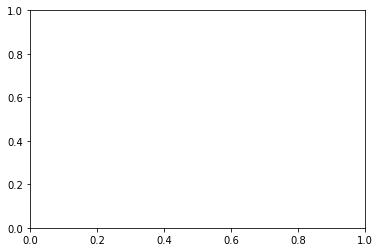

In [10]:
plt.plot(m)